# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [2]:
import tensorflow as tf
from scipy.io import loadmat

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [3]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [5]:
train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [6]:
X_train = train['X']
y_train = train['y'] - 1 # conver to 0 based

X_test = test['X']
y_test = test['y'] - 1 # convert to 0-based

print('Train X:' , train['X'].shape ,'Train y:',train['y'].shape)
print('Test X:' ,test['X'].shape,'Test y:' ,test['y'].shape)

Train X: (32, 32, 3, 73257) Train y: (73257, 1)
Test X: (32, 32, 3, 26032) Test y: (26032, 1)


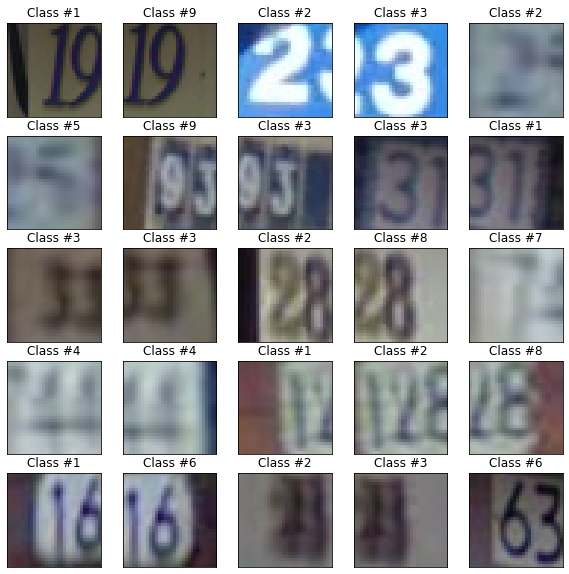

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

num_cols = 5;
num_rows = 5;

fig, ax = plt.subplots(num_rows,num_cols,figsize = (10,10))

example_i = 0
for i in range(num_rows):
    for j in range(num_cols):  
        ax[i,j].imshow(X_train[:,:,:,example_i])
        ax[i,j].set_title('Class #' + str(y_train[example_i][0]%10+1))
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
        example_i += 1

In [8]:
import numpy as np

In [9]:
X_train_grayscale = np.mean(X_train,axis = 2,keepdims = True)
X_test_grayscale = np.mean(X_test,axis = 2,keepdims = True)

print('Train X:' , X_train_grayscale.shape )
print('Test X:' ,X_test_grayscale.shape)


Train X: (32, 32, 1, 73257)
Test X: (32, 32, 1, 26032)


In [10]:
X_train_grayscale = X_train_grayscale.transpose((-1,0,1,2)) / 255.
X_test_grayscale  = X_test_grayscale.transpose((-1,0,1,2)) / 255.

print('Train X:' , X_train_grayscale.shape )
print('Test X:' ,X_test_grayscale.shape)

Train X: (73257, 32, 32, 1)
Test X: (26032, 32, 32, 1)


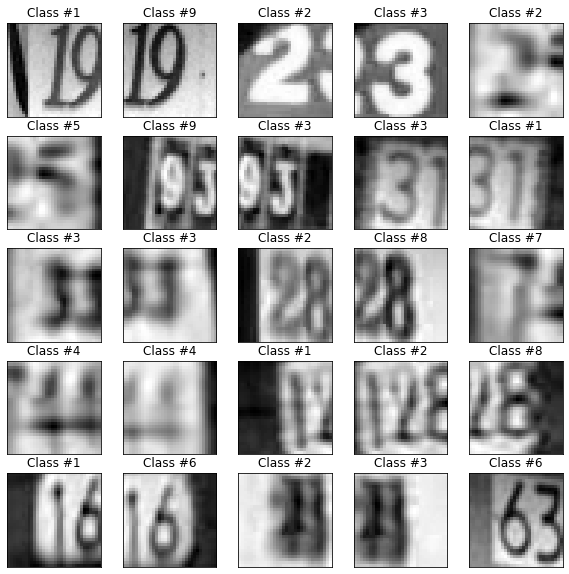

In [11]:
num_cols = 5;
num_rows = 5;

fig, ax = plt.subplots(num_rows,num_cols,figsize = (10,10))
example_i = 0
for i in range(num_rows):
    for j in range(num_cols):  
        ax[i,j].imshow(X_train_grayscale[example_i,:,:,0], cmap = 'gray')
        ax[i,j].set_title('Class #' + str(y_train[example_i][0]%10+1))
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
        example_i += 1

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [13]:
checkpoint_cb_cnn = ModelCheckpoint(filepath = 'model_checkpoint_CNN',
                                monitor = 'val_accuracy',
                                mode = 'max',
                                save_weights_only = True,
                                save_best_only = True, 
                                save_freq = 'epoch',
                                verbose = True)

checkpoint_cb_mlp = ModelCheckpoint(filepath = 'model_checkpoint_MLP',
                                monitor = 'val_accuracy',
                                mode = 'max',
                                save_weights_only = True,
                                save_best_only = True, 
                                save_freq = 'epoch',
                                verbose = True)

early_stopping_cb = EarlyStopping(monitor = 'val_loss',mode = 'min',patience = 5,verbose = True)

l2_reg = l2(1e-5)

In [14]:
model = Sequential([
    Flatten(input_shape = (32,32,1),name = 'Flatten_1'),
    Dense(128*4,activation = 'relu',kernel_regularizer = l2_reg,name = 'Dense_1'),
    Dropout(0.2),
    Dense(128,activation = 'relu',kernel_regularizer = l2_reg,name = 'Dense_2'),
    Dense(64,activation = 'relu',kernel_regularizer = l2_reg,name = 'Dense_3'),
    Dense(32,activation = 'relu',kernel_regularizer = l2_reg,name = 'Dense_4'),
    Dense(10,activation = 'softmax',kernel_regularizer = l2_reg,name = 'Dense_5'),
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
Dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
Dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
Dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
Dense_5 (Dense)              (None, 10)                3

In [16]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [188]:
history_mlp = model.fit(X_train_grayscale,y_train,
          epochs = 25,
          batch_size = 512,
          validation_data = (X_test_grayscale,y_test),
          callbacks = [checkpoint_cb_mlp, early_stopping_cb])

Train on 73257 samples, validate on 26032 samples
Epoch 1/25
73216/73257 [============================>.] - ETA: 0s - loss: 0.8405 - accuracy: 0.7362
Epoch 00001: val_accuracy improved from -inf to 0.72276, saving model to model_checkpoint_MLP
73257/73257 [==============================] - 37s 508us/sample - loss: 0.8406 - accuracy: 0.7361 - val_loss: 0.8994 - val_accuracy: 0.7228
Epoch 2/25
73216/73257 [============================>.] - ETA: 0s - loss: 0.8391 - accuracy: 0.7355
Epoch 00002: val_accuracy improved from 0.72276 to 0.73218, saving model to model_checkpoint_MLP
73257/73257 [==============================] - 29s 402us/sample - loss: 0.8391 - accuracy: 0.7355 - val_loss: 0.8701 - val_accuracy: 0.7322
Epoch 3/25
73216/73257 [============================>.] - ETA: 0s - loss: 0.8432 - accuracy: 0.7349
Epoch 00003: val_accuracy improved from 0.73218 to 0.74082, saving model to model_checkpoint_MLP
73257/73257 [==============================] - 30s 412us/sample - loss: 0.8432 - a

In [19]:
model.load_weights('model_checkpoint_MLP')
loss, accuracy = model.evaluate(X_test_grayscale,y_test, batch_size = 512, verbose = 2)

26032/1 - 4s - loss: 0.7224 - accuracy: 0.7637


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df_mlp = pd.DataFrame(history_mlp.history)
df_mlp.head()

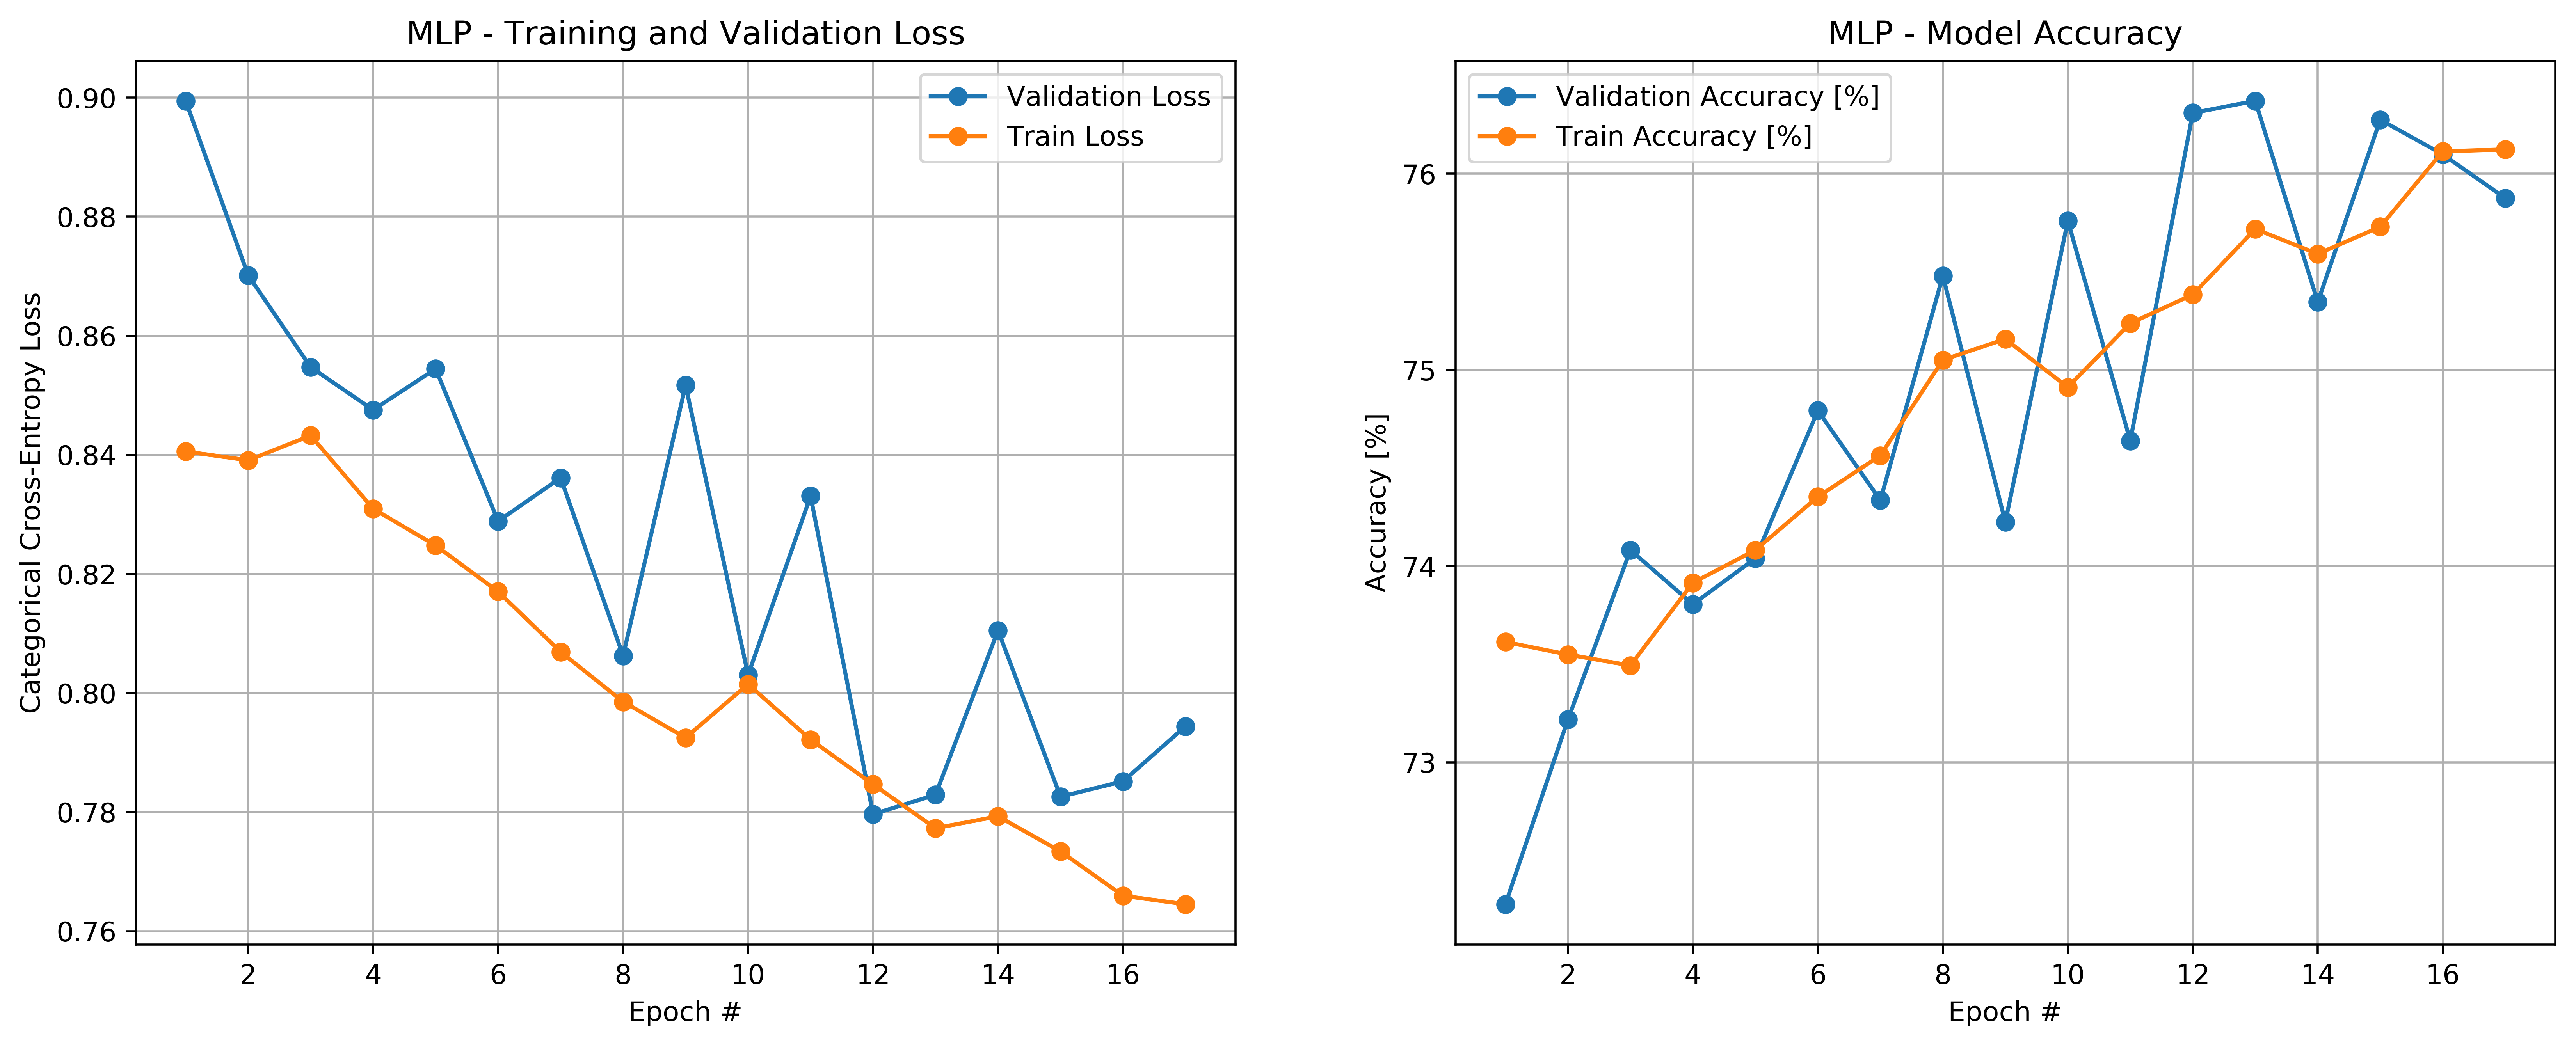

In [207]:
fig, ax = plt.subplots(1,2,figsize = (16,6), dpi = 500)

ax[0].plot(np.arange(1,18),df_mlp.val_loss,'-o')
ax[0].plot(np.arange(1,18),df_mlp.loss,'-o')
ax[0].legend(['Validation Loss','Train Loss'])
ax[0].grid()
ax[0].set_xlabel('Epoch #')
ax[0].set_ylabel('Categorical Cross-Entropy Loss')
ax[0].set_title('MLP - Training and Validation Loss')

ax[1].plot(np.arange(1,18),df_mlp.val_accuracy * 100,'-o')
ax[1].plot(np.arange(1,18),df_mlp.accuracy * 100,'-o')
ax[1].legend(['Validation Accuracy [%]','Train Accuracy [%]'])
ax[1].grid()
ax[1].set_xlabel('Epoch #')
ax[1].set_ylabel('Accuracy [%]')
ax[1].set_title('MLP - Model Accuracy')
plt.show()

In [ ]:
idx = np.random.choice(X_test_grayscale.shape[0],10000)
random_test_images = X_test_grayscale[idx,...]
y_pred = model.predict(random_test_images)

np.mean(y_pred.argmax(axis = 1) == y_test[idx].squeeze()) * 100

cm_mlp = confusion_matrix(y_test[idx].squeeze(),y_pred.argmax(axis = 1))

fig, ax = plt.subplots(figsize=(7,6), dpi = 100)
sns.heatmap(cm_mlp/np.sum(cm_mlp,axis = 0),annot = True,fmt = '.1%',ax = ax,cmap = 'coolwarm')
plt.title('Confusion Matrix - MLP')
plt.show()

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [20]:
from tensorflow.keras.layers import Conv2D, MaxPool2D

In [21]:
model_cnn = Sequential([
    Conv2D(16,(3,3),padding = 'SAME',kernel_regularizer = l2_reg, input_shape = X_train_grayscale[0].shape),
    MaxPool2D((2,2)),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(4,(3,3),padding = 'SAME',kernel_regularizer = l2_reg),
    MaxPool2D((2,2)),
    Conv2D(2,(3,3),padding = 'SAME',kernel_regularizer = l2_reg),
    Flatten(),
    Dense(32, activation = 'relu',kernel_regularizer = l2_reg),
    Dense(10, activation = 'softmax',kernel_regularizer = l2_reg)
])

In [22]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 16)        64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 4)         580       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 4)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 2)          

In [23]:
model_cnn.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_cnn = model_cnn.fit(X_train_grayscale,y_train,
          epochs = 25,
          batch_size = 512,
          validation_data = (X_test_grayscale,y_test),
          callbacks = [checkpoint_cb_cnn, early_stopping_cb])

Train on 73257 samples, validate on 26032 samples
Epoch 1/25
73216/73257 [============================>.] - ETA: 0s - loss: 2.2185 - accuracy: 0.1990
Epoch 00001: val_accuracy improved from -inf to 0.18262, saving model to model_checkpoint_CNN
73257/73257 [==============================] - 198s 3ms/sample - loss: 2.2184 - accuracy: 0.1990 - val_loss: 2.2668 - val_accuracy: 0.1826
Epoch 2/25
73216/73257 [============================>.] - ETA: 0s - loss: 1.6129 - accuracy: 0.4576
Epoch 00002: val_accuracy improved from 0.18262 to 0.32456, saving model to model_checkpoint_CNN
73257/73257 [==============================] - 215s 3ms/sample - loss: 1.6127 - accuracy: 0.4577 - val_loss: 1.9644 - val_accuracy: 0.3246
Epoch 3/25
73216/73257 [============================>.] - ETA: 0s - loss: 1.0822 - accuracy: 0.6600
Epoch 00003: val_accuracy improved from 0.32456 to 0.66726, saving model to model_checkpoint_CNN
73257/73257 [==============================] - 202s 3ms/sample - loss: 1.0821 - accu

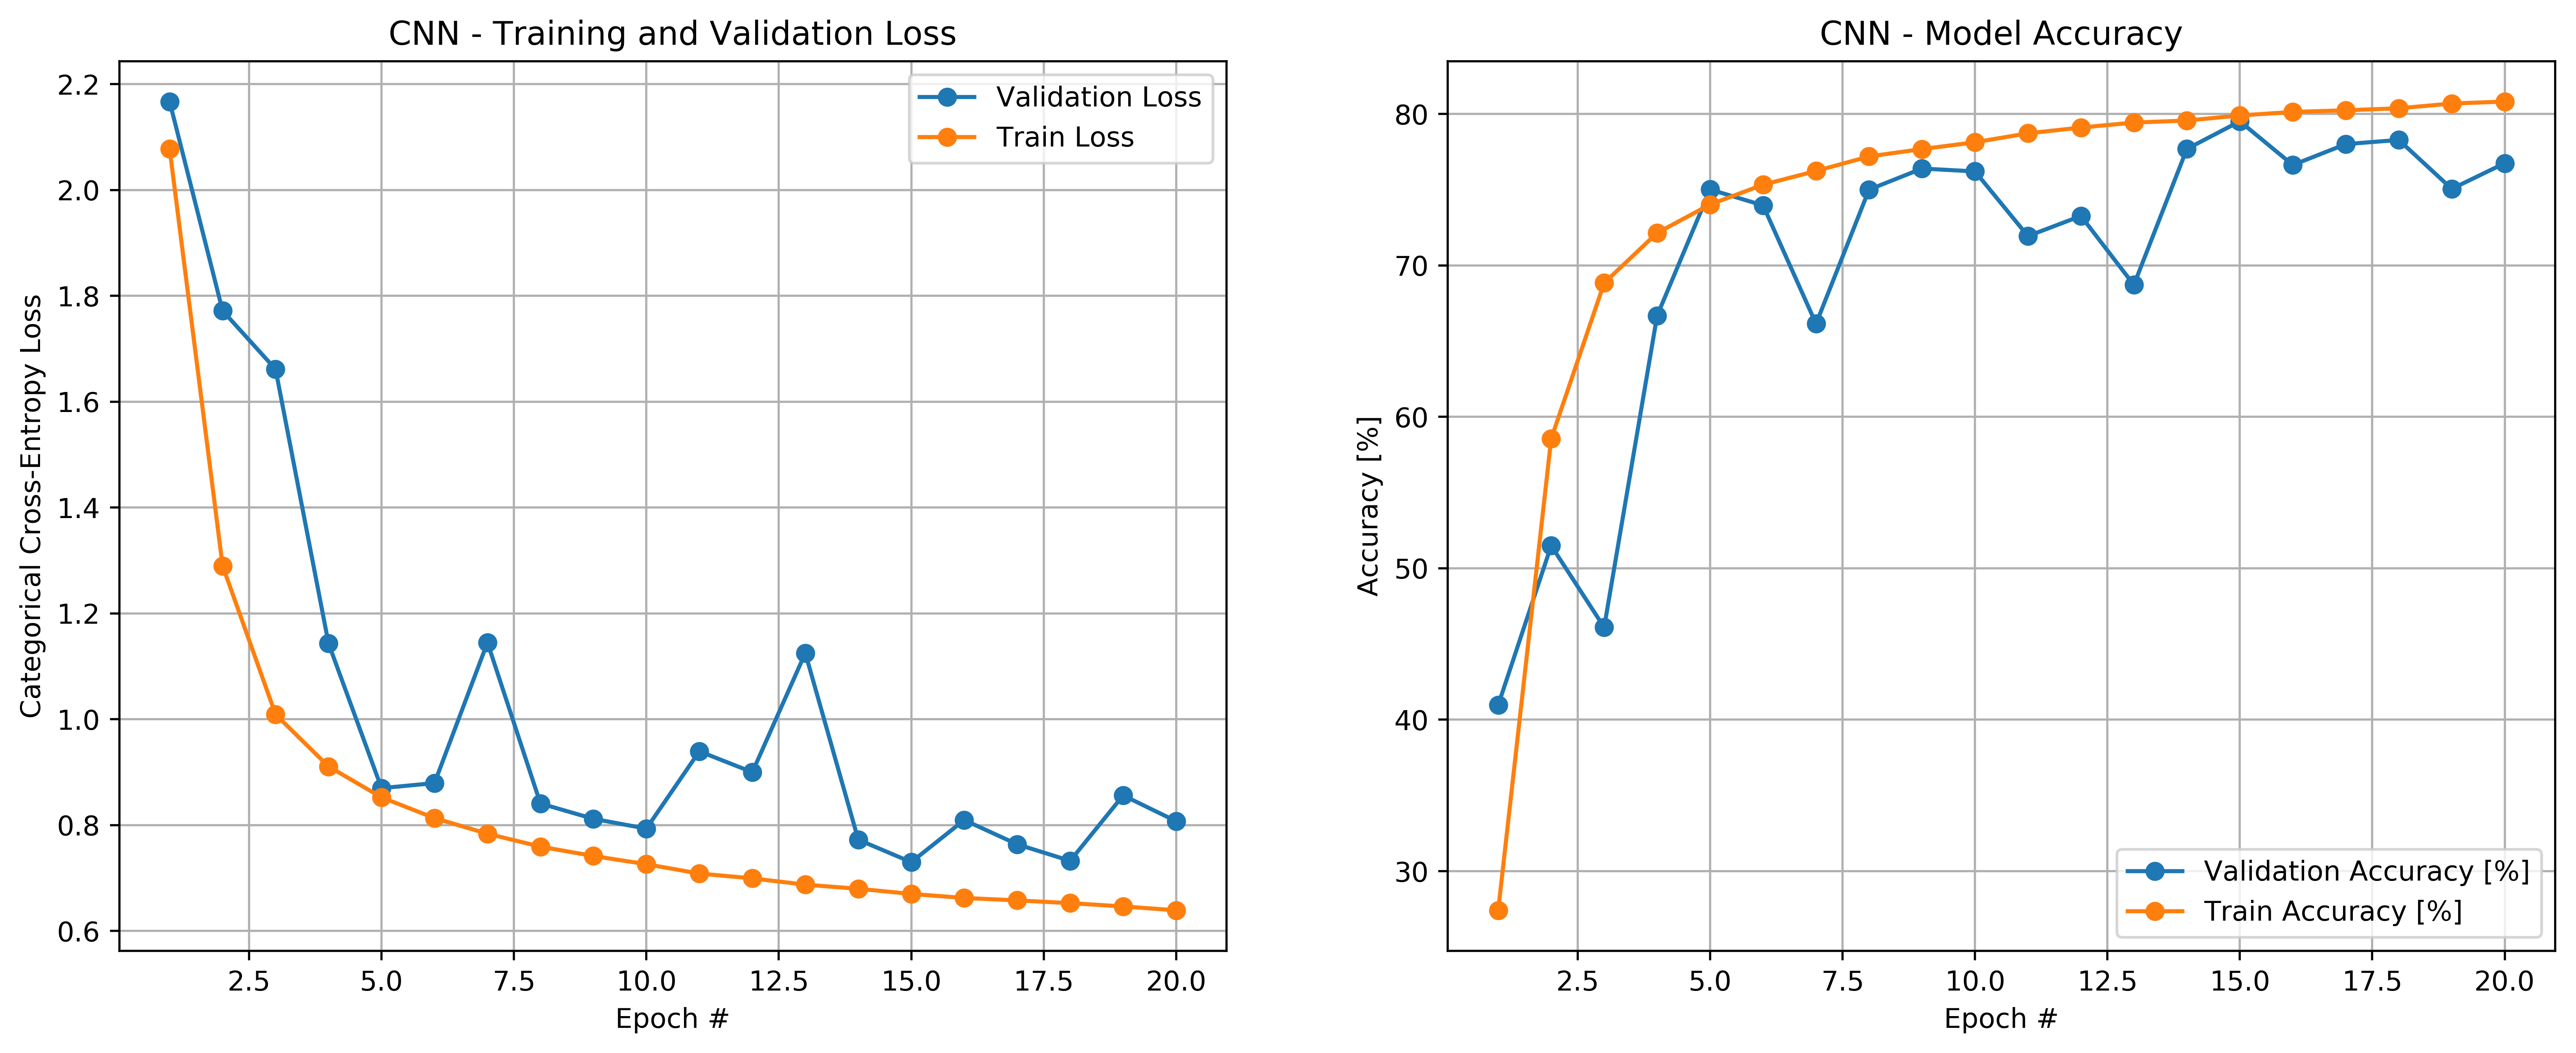

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(history_cnn.history)
fig, ax = plt.subplots(1,2,figsize = (16,6), dpi = 500)

ax[0].plot(np.arange(1,21),df.val_loss,'-o')
ax[0].plot(np.arange(1,21),df.loss,'-o')
ax[0].legend(['Validation Loss','Train Loss'])
ax[0].grid()
ax[0].set_xlabel('Epoch #')
ax[0].set_ylabel('Categorical Cross-Entropy Loss')
ax[0].set_title('CNN - Training and Validation Loss')

ax[1].plot(np.arange(1,21),df.val_accuracy * 100,'-o')
ax[1].plot(np.arange(1,21),df.accuracy * 100,'-o')
ax[1].legend(['Validation Accuracy [%]','Train Accuracy [%]'])
ax[1].grid()
ax[1].set_xlabel('Epoch #')
ax[1].set_ylabel('Accuracy [%]')
ax[1].set_title('CNN - Model Accuracy')
plt.show()

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [26]:
!ls -lh

total 16M
-rwxrwxrwx 1 nobody nogroup 1.8M Oct 15 17:34 'Capstone Project.ipynb'
-rw-r--r-- 1 jovyan users     97 Oct 12 21:23  checkpoint
drwxrwxrwx 2 nobody nogroup 6.0K Oct  2 19:50  data
-rw-r--r-- 1 jovyan users    68K Oct 12 21:23  model_checkpoint_CNN.data-00000-of-00001
-rw-r--r-- 1 jovyan users   2.9K Oct 12 21:23  model_checkpoint_CNN.index
-rw-r--r-- 1 jovyan users   6.9M Oct 10 20:41  model_checkpoint.data-00000-of-00001
-rw-r--r-- 1 jovyan users   2.4K Oct 10 20:41  model_checkpoint.index
-rw-r--r-- 1 jovyan users   6.9M Oct 10 20:49  model_checkpoint_MLP.data-00000-of-00001
-rw-r--r-- 1 jovyan users   2.4K Oct 10 20:49  model_checkpoint_MLP.index


In [31]:
model_cnn.load_weights('model_checkpoint_CNN')

idx = np.random.choice(X_test_grayscale.shape[0],10000)
random_test_images = X_test_grayscale[idx,...]
y_pred = model_cnn.predict(random_test_images)

ValueError: Shapes (1024, 512) and (3, 3, 1, 16) are incompatible

In [135]:
np.mean(y_pred.argmax(axis = 1) == y_test[idx].squeeze()) * 100

79.73

In [136]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [137]:
cm = confusion_matrix(y_test[idx].squeeze(),y_pred.argmax(axis = 1))

In [ ]:
fig, ax = plt.subplots(figsize=(7,6), dpi = 100)
sns.heatmap(cm/np.sum(cm,axis = 0),annot = True,fmt = '.1%',ax = ax,cmap = 'coolwarm')
plt.title('Confusion Matrix - CNN')
plt.show()

In [29]:
model.load_weights('model_checkpoint')

idx = np.random.choice(X_test_grayscale.shape[0],10000)
random_test_images = X_test_grayscale[idx,...]
y_pred = model.predict(random_test_images)
np.mean(y_pred.argmax(axis = 1) == y_test[idx].squeeze()) * 100

73.91

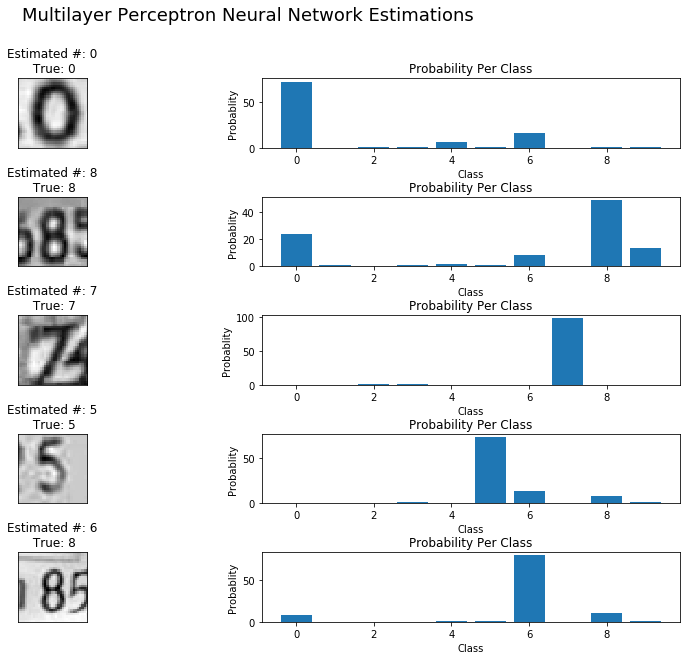

In [118]:
f, ax = plt.subplots(5,2,figsize = (15,10))
plt.subplots_adjust(hspace = 0.7, wspace = 0)
f.suptitle('Multilayer Perceptron Neural Network Estimations', fontsize = 18)
for i in range(5):
    ax[i,0].imshow(random_test_images[i,:,:,:].squeeze(), cmap = 'gray')
    ax[i,0].set_title('Estimated #: ' + str((y_pred.argmax(axis = 1)[i]+1)%10 ) + '\n True: ' + str((y_test[idx].squeeze()[i]+1)%10))
    ax[i,0].get_xaxis().set_visible(False)
    ax[i,0].get_yaxis().set_visible(False)
    ax[i,1].bar(np.arange(10),np.roll(y_pred[i,:],1)*100)
    ax[i,1].set_title('Probability Per Class')
    ax[i,1].set_ylabel('Probablity')
    ax[i,1].set_xlabel('Class')